In [10]:
## data
import pandas as pd
import numpy as np
import datetime as dt
from dateutil.relativedelta import relativedelta
from unicodedata import normalize

## vis
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
# contagem de aging
from collections import Counter

from IPython.display import display, HTML

## modelo
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# check xgboost version
from xgboost import XGBClassifier

## alertas
import warnings
warnings.filterwarnings("ignore")

***
## Coleta de dados

In [11]:
FILE = "/kaggle/input/datasetsnew/batdtfim500kage.csv"
dados = pd.read_csv(FILE, sep = ';', encoding = 'ISO-8859-1', engine ='python')

dados = dados.rename(columns={'a.msisdn': 'msisdn'})\
             .rename(columns={'a.imsi': 'imsi'})\
             .rename(columns={'a.tac': 'tac'})\
             .rename(columns={'a.dt_inicio': 'dt_inicio'})\
             .rename(columns={'a.dt_fim': 'dt_fim'})\
             .rename(columns={'a.aging_aparelho': 'aging_aparelho'})\
             .rename(columns={'a.cat_aparelho': 'cat_aparelho'})\
             .rename(columns={'a.trocou_aparelho': 'trocou_aparelho'})\
             .rename(columns={'a.fabricante': 'fabricante'})\
             .rename(columns={'a.modelo': 'modelo'})\
             .rename(columns={'a.imei': 'imei'})\
             .rename(columns={'a.ranking': 'ranking'})\
             .rename(columns={'a.cpfidentifier': 'cpfidentifier'})\
             .rename(columns={'a.subscriberkey': 'subscriberkey'})\
             .rename(columns={'a.customerkey': 'customerkey'})\
             .rename(columns={'a.customersubtypedesc': 'customersubtypedesc'})\
             .rename(columns={'a.subscriberstatuskey': 'subscriberstatuskey'})\
             .rename(columns={'a.offertechnology': 'offertechnology'})\
             .rename(columns={'a.citydesc': 'citydesc'})\
             .rename(columns={'a.statedesc': 'statedesc'})\
             .rename(columns={'a.subscribermainofferdesc': 'subscribermainofferdesc'})\
             .rename(columns={'a.assignedchargeamount': 'assignedchargeamount'})\
             .rename(columns={'a.fl_3g': 'fl_3g'})\
             .rename(columns={'a.fl_4g': 'fl_4g'})\
             .rename(columns={'a.fl_5g': 'fl_5g'})\
             .rename(columns={'a.dt_ano_stts': 'dt_ano_stts'})\
             .rename(columns={'a.idade': 'idade'})\

dados = dados[dados['offertechnology'] == 'PostPaid']

dados

,msisdn,imsi,tac,dt_inicio,dt_fim,aging_aparelho,cat_aparelho,trocou_aparelho,fabricante,modelo,...,offertechnology,citydesc,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,fl_5g,dt_ano_stts,idade
0,5532998068556,724235404829984,35415808,2021-02-17,2022-04-09,13,1,1,SAMSUNG,GALAXY J7 PRIME (SM-G610M DS),...,PostPaid,NaN,MINAS GERAIS,LINHA ADICIONAL VIVO FAMÃLIA 150GB,0.00,0.0,1.0,0.0,2016.0,31
2,5555999595054,724065007509989,35175119,2021-03-31,NaN,18,1,0,SAMSUNG,"GALAXY S21 PLUS 5G (SM-G996B,DS)",...,PostPaid,NaN,RIO GRANDE DO SUL,LINHA ADICIONAL VIVO FAMILIA 100GB,0.00,0.0,0.0,1.0,2020.0,56
5,5514997573988,724102006884141,35855882,2021-02-21,2022-03-28,13,1,1,Samsung Korea,GALAXY S20 FE,...,PostPaid,NaN,SAO PAULO,TITULAR VIVO PÃS MIG_20GB,103.16,0.0,1.0,0.0,2020.0,35
7,5535999691624,724233610358155,35267276,2021-03-25,NaN,18,1,0,APPLE,IPHONE 11 (A2221),...,PostPaid,NaN,MINAS GERAIS,LINHA ADICIONAL VIVO FAMILIA 20GB+220GB BONUS,0.00,0.0,1.0,0.0,2020.0,55
8,5592994714026,724119792517930,35729112,2021-07-16,NaN,15,1,0,LG,LM-K420BMW,...,PostPaid,NaN,AMAZONAS,TITULAR VIVO POS 30GB - MENSAL,32.11,0.0,1.0,0.0,2021.0,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499974,5544991136960,724064006631425,35721410,2021-07-14,NaN,15,1,0,"Motorola Mobility LLC, a Lenovo Company",MOTO E PLAY (5TH GEN),...,PostPaid,NaN,PARANA,LINHA ADICIONAL VIVO FAMILIA 200GB,62.99,0.0,1.0,0.0,2019.0,38
499984,5565999036799,724066612247984,35531751,2021-09-23,NaN,12,1,0,SAMSUNG,"GALAXY S21 PLUS 5G (SM-G996B,DS)",...,PostPaid,NaN,MATO GROSSO,TITULAR VIVO FAMILIA 200GB,471.99,0.0,0.0,1.0,2020.0,29
499994,5519981197556,724102293424867,35057056,2021-04-11,NaN,18,1,0,SAMSUNG,"GALAXY S21 PLUS 5G (SM-G996B,DS)",...,PostPaid,NaN,SAO PAULO,TITULAR VIVO SELFIE GLOBOPLAY 30GB,134.99,0.0,0.0,1.0,2020.0,69
499995,5541992819276,724064006643479,35892323,2021-05-06,NaN,17,1,0,Samsung Korea,GALAXY A52 5G,...,PostPaid,NaN,PARANA,LINHA ADICIONAL VIVO FAMILIA 150GB,0.00,0.0,0.0,1.0,2020.0,63


### Limpeza dos dados

In [12]:
def just_check_nan(df):
    # Check NaN Pandas and Numpy
    missing_val_count_by_column = (df.isna().sum())

    columns_with_nan = missing_val_count_by_column[missing_val_count_by_column > 0]
    print('Dados com NaN:')
    print(columns_with_nan)
    print('')
    print('columns_with_nan.shape', columns_with_nan.shape)
    print('')

In [13]:
just_check_nan(dados)

Dados com NaN:
dt_fim                     114974
citydesc                   141227
statedesc                      61
subscribermainofferdesc       698
assignedchargeamount          683
fl_3g                          38
fl_4g                          38
fl_5g                          38
dt_ano_stts                    38
dtype: int64

columns_with_nan.shape (9,)



In [14]:
dados_droped = dados.dropna(subset=['imsi',
                                    'statedesc', 
                                    'subscribermainofferdesc', 
                                    'assignedchargeamount', 'fl_3g', 'fl_4g', 'fl_5g', 'dt_ano_stts'])\
                    .reset_index(drop=True)
# dados_droped

In [15]:
just_check_nan(dados_droped)

Dados com NaN:
dt_fim      114552
citydesc    140413
dtype: int64

columns_with_nan.shape (2,)



### Equilibrando classes

In [16]:
dados_droped_0 = dados_droped[dados_droped['trocou_aparelho'] == 0].sample(frac=0.53, random_state=3)
dados_droped_1 = dados_droped[dados_droped['trocou_aparelho'] == 1]

In [17]:
dados_droped = pd.concat([dados_droped_0, dados_droped_1]).reset_index(drop=True).sort_values(by='msisdn', ascending=False)
dados_droped

,msisdn,imsi,tac,dt_inicio,dt_fim,aging_aparelho,cat_aparelho,trocou_aparelho,fabricante,modelo,...,offertechnology,citydesc,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,fl_5g,dt_ano_stts,idade
80189,5599999778280,724119113878348,35768964,2021-05-17,2022-05-19,12,1,1,Samsung Korea,GALAXY NOTE20 ULTRA 5G,...,PostPaid,NaN,MARANHAO,TITULAR VIVO SELFIE - AMAZON PRIME - 20GB,109.99,0.0,0.0,1.0,2020.0,63
59203,5599999778280,724119113878348,35768964,2021-05-17,2022-05-19,12,1,1,Samsung Korea,GALAXY NOTE20 ULTRA 5G,...,PostPaid,NaN,MARANHAO,TITULAR VIVO SELFIE - AMAZON PRIME - 20GB,109.99,0.0,0.0,1.0,2020.0,63
78467,5599999770208,724119112384725,35767712,2021-05-04,2022-05-17,12,1,1,APPLE,IPHONE 12 PRO MAX (A2411),...,PostPaid,NaN,MARANHAO,LINHA ADICIONAL VIVO V,0.00,0.0,0.0,1.0,2020.0,29
12464,5599999530131,724119114015020,35260709,2021-07-09,NaN,15,1,0,SAMSUNG,GALAXY J7 PRIME (SM-G610M DS),...,PostPaid,NaN,MARANHAO,LINHA ADICIONAL VIVO FAMILIA 200GB,0.00,0.0,1.0,0.0,2017.0,30
86032,5599999514361,724119896599952,35734809,2021-01-08,2022-02-09,13,1,1,APPLE,IPHONE XR (A1984),...,PostPaid,NaN,MARANHAO,LINHA ADICIONAL VIVO FAMILIA 100GB,0.00,0.0,1.0,0.0,2018.0,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19540,5511910007006,724102008238085,35179738,2021-04-12,NaN,18,1,0,SAMSUNG,GALAXY A01 (SM-A015M),...,PostPaid,NaN,SAO PAULO,Linha Adicional Plano PÃ³s Vivo V 600GB,0.00,0.0,1.0,0.0,2020.0,48
65219,5511910003326,724102090904887,35187408,2021-02-03,2022-05-02,14,1,1,"Motorola Mobility LLC, a Lenovo Company","MOTO G (4TH GEN), AF12788145",...,PostPaid,NaN,SAO PAULO,Titular INTERNET_MOVEL_100GB,112.30,0.0,1.0,0.0,2016.0,48
29886,5511910001745,724102802140721,35188909,2021-09-21,NaN,12,1,0,MOTOROLA,MOTOROLA MOTO G5S (XT1792),...,PostPaid,NaN,SAO PAULO,LINHA ADICIONAL VIVO FAMILIA 200GB,0.00,0.0,1.0,0.0,2017.0,36
22621,5511910001745,724102802140721,35188909,2021-09-21,NaN,12,1,0,MOTOROLA,MOTOROLA MOTO G5S (XT1792),...,PostPaid,NaN,SAO PAULO,LINHA ADICIONAL VIVO FAMILIA 200GB,0.00,0.0,1.0,0.0,2017.0,36


In [18]:
# checando balanço das classes
y_trocou_aparelho = dados_droped['trocou_aparelho']

c_trocou_aparelho = Counter(y_trocou_aparelho)
c_trocou_aparelho

Counter({1: 29060, 0: 59017})

In [19]:
dados_droped = dados_droped.tail(dados_droped.shape[0] -70000).reset_index(drop=True)
dados_droped['dt_ano_stts'] = dados_droped['dt_ano_stts'].astype(np.int64).reset_index(drop=True)
# dados_droped2 = dados_droped[dados_droped['trocou_aparelho'] == 1].reset_index()
dados_droped

,msisdn,imsi,tac,dt_inicio,dt_fim,aging_aparelho,cat_aparelho,trocou_aparelho,fabricante,modelo,...,offertechnology,citydesc,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,fl_5g,dt_ano_stts,idade
0,5513991038448,724102596295320,35411609,2021-02-04,2022-04-11,14,1,1,MOTOROLA,MOTOROLA MOTO G5S (XT1792),...,PostPaid,NaN,SAO PAULO,Titular Vivo PÃ³s FamÃ­lia 120GB,138.99,0.0,1.0,0.0,2017,58
1,5513991036083,724102111954489,35645410,2021-08-15,NaN,14,1,0,APPLE,IPHONE XR (A2105),...,PostPaid,NaN,SAO PAULO,TITULAR VIVO SELFIE SPOTIFY PREMIUM 30GB,129.99,0.0,1.0,0.0,2019,20
2,5513991030514,724101890587888,35308810,2021-10-09,NaN,12,1,0,APPLE,IPHONE XR (A2105),...,PostPaid,NaN,SAO PAULO,TITULAR VIVO SELFIE ESSENCIAL 20GB,101.99,0.0,1.0,0.0,2018,39
3,5513991024700,724102004684244,35787982,2021-07-04,NaN,15,1,0,APPLE,IPHONE 11 (A2221),...,PostPaid,NaN,SAO PAULO,TITULAR VIVO FAMILIA 100GB,319.99,0.0,1.0,0.0,2020,32
4,5513991020962,724102293740407,86630005,2021-06-19,NaN,16,1,0,XIAOMI,REDMI 9A (M2006C3LI),...,PostPaid,NaN,SAO PAULO,TITULAR PLANO VIVO_POS 30GB,134.99,0.0,1.0,0.0,2020,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18072,5511910007006,724102008238085,35179738,2021-04-12,NaN,18,1,0,SAMSUNG,GALAXY A01 (SM-A015M),...,PostPaid,NaN,SAO PAULO,Linha Adicional Plano PÃ³s Vivo V 600GB,0.00,0.0,1.0,0.0,2020,48
18073,5511910003326,724102090904887,35187408,2021-02-03,2022-05-02,14,1,1,"Motorola Mobility LLC, a Lenovo Company","MOTO G (4TH GEN), AF12788145",...,PostPaid,NaN,SAO PAULO,Titular INTERNET_MOVEL_100GB,112.30,0.0,1.0,0.0,2016,48
18074,5511910001745,724102802140721,35188909,2021-09-21,NaN,12,1,0,MOTOROLA,MOTOROLA MOTO G5S (XT1792),...,PostPaid,NaN,SAO PAULO,LINHA ADICIONAL VIVO FAMILIA 200GB,0.00,0.0,1.0,0.0,2017,36
18075,5511910001745,724102802140721,35188909,2021-09-21,NaN,12,1,0,MOTOROLA,MOTOROLA MOTO G5S (XT1792),...,PostPaid,NaN,SAO PAULO,LINHA ADICIONAL VIVO FAMILIA 200GB,0.00,0.0,1.0,0.0,2017,36


In [20]:
dados_droped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18077 entries, 0 to 18076
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   msisdn                   18077 non-null  int64  
 1   imsi                     18077 non-null  int64  
 2   tac                      18077 non-null  int64  
 3   dt_inicio                18077 non-null  object 
 4   dt_fim                   5068 non-null   object 
 5   aging_aparelho           18077 non-null  int64  
 6   cat_aparelho             18077 non-null  int64  
 7   trocou_aparelho          18077 non-null  int64  
 8   fabricante               18077 non-null  object 
 9   modelo                   18077 non-null  object 
 10  imei                     18077 non-null  object 
 11  ranking                  18077 non-null  int64  
 12  cpfidentifier            18077 non-null  int64  
 13  subscriberkey            18077 non-null  int64  
 14  customerkey           

***
### Analise individual

In [21]:
dados_droped['cat_aparelho'].unique()

array([1])

In [22]:
dados_droped['trocou_aparelho'].unique()

array([1, 0])

In [23]:
dados_droped['aging_aparelho'].unique()

array([14, 12, 15, 16, 13, 17, 18])

In [24]:
dados_droped['customersubtypedesc'].unique()

array(['Pessoa FÃ\xadsica'], dtype=object)

In [25]:
dados_droped['subscriberstatuskey'].unique()

array(['A'], dtype=object)

In [26]:
dados_droped['ranking'].unique()

array([1, 2])

In [27]:
dados_droped['assignedchargeamount'].unique()

array([ 138.99,  129.99,  101.99,  319.99,  134.99,   60.82,  109.99,
        115.  ,    0.  ,  150.51,   94.01,  159.99,   88.99,  876.7 ,
        127.64,  112.3 ,   98.99,  158.99,  169.99,  235.13,  299.99,
        168.99,   92.99,  283.42,   62.99,  629.99,   48.99,  529.99,
        590.63,  119.99,  126.98,  308.99,   14.9 ,   99.99,   64.  ,
        103.16,  124.  ,   83.89,  106.  ,  101.1 ,  399.99,  113.92,
        489.99,  338.99,   96.99,  318.99,  288.99,  960.7 ,  429.98,
        107.91,   94.99,  369.89,  173.89,  124.99,  208.99,  139.99,
         91.6 ,  121.63,   73.16,   77.2 ,  176.26,   64.01,  238.99,
         69.99,  244.36,  117.99,  223.13,  -11.19,  189.99,  126.02,
        840.7 ,  852.01,  132.99,   49.99, 1179.99,   44.99,  170.5 ,
        249.99,  394.99,   80.08,   30.  ,  263.99,  239.98,  124.98,
         60.19,  269.8 ,  329.98,  100.2 ,   66.5 ,  265.12,  886.81,
        219.98,  179.23,   14.99,    9.99,  429.99,  167.98, 2190.98,
        129.98,  234

In [28]:
dados_droped['fl_3g'].equals(dados_droped['fl_4g'])

False

In [29]:
dados_droped['fl_3g'].equals(dados_droped['fl_5g'])

False

In [30]:
dados_droped['fl_4g'].equals(dados_droped['fl_5g'])

False

In [31]:
dados_droped['trocou_aparelho'].unique()

array([1, 0])

In [32]:
dados_droped['idade'].unique()

array([ 58,  20,  39,  32,  61,  66,  54,  43,  33,  52,  31,  59,  41,
        29,  27,  45,  28,  67,  42,  22,  36,  40,  37,  60,  56,  49,
        62,  70,  34,  69,  48,  38,  46,  50,  35,  55,  93,  71,  72,
        64,  26,  51,  68,  47,  63,  53,  57,  44,  25,  30,  83,  65,
        24,  74,  73,  80,  79,  78,  82,  75,  21,  76,  86,  89,  77,
        87,  23,  81,  19,  84,  88, 122,   2,  90,  85,  92, 150,   0,
       146,   1,  12,  18, 101])

***
## Exploração dos dados

### seleção de features

In [33]:
# define features
X_ta = dados_droped[['fabricante', 'modelo', 'ranking', 'aging_aparelho', 
                     'offertechnology', 
                     'statedesc', 'subscribermainofferdesc', 'assignedchargeamount', 
                     'fl_3g', 'fl_4g', 'fl_5g', 'dt_ano_stts', 'idade']]
X_ta

,fabricante,modelo,ranking,aging_aparelho,offertechnology,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,fl_5g,dt_ano_stts,idade
0,MOTOROLA,MOTOROLA MOTO G5S (XT1792),1,14,PostPaid,SAO PAULO,Titular Vivo PÃ³s FamÃ­lia 120GB,138.99,0.0,1.0,0.0,2017,58
1,APPLE,IPHONE XR (A2105),1,14,PostPaid,SAO PAULO,TITULAR VIVO SELFIE SPOTIFY PREMIUM 30GB,129.99,0.0,1.0,0.0,2019,20
2,APPLE,IPHONE XR (A2105),1,12,PostPaid,SAO PAULO,TITULAR VIVO SELFIE ESSENCIAL 20GB,101.99,0.0,1.0,0.0,2018,39
3,APPLE,IPHONE 11 (A2221),1,15,PostPaid,SAO PAULO,TITULAR VIVO FAMILIA 100GB,319.99,0.0,1.0,0.0,2020,32
4,XIAOMI,REDMI 9A (M2006C3LI),1,16,PostPaid,SAO PAULO,TITULAR PLANO VIVO_POS 30GB,134.99,0.0,1.0,0.0,2020,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18072,SAMSUNG,GALAXY A01 (SM-A015M),1,18,PostPaid,SAO PAULO,Linha Adicional Plano PÃ³s Vivo V 600GB,0.00,0.0,1.0,0.0,2020,48
18073,"Motorola Mobility LLC, a Lenovo Company","MOTO G (4TH GEN), AF12788145",1,14,PostPaid,SAO PAULO,Titular INTERNET_MOVEL_100GB,112.30,0.0,1.0,0.0,2016,48
18074,MOTOROLA,MOTOROLA MOTO G5S (XT1792),1,12,PostPaid,SAO PAULO,LINHA ADICIONAL VIVO FAMILIA 200GB,0.00,0.0,1.0,0.0,2017,36
18075,MOTOROLA,MOTOROLA MOTO G5S (XT1792),1,12,PostPaid,SAO PAULO,LINHA ADICIONAL VIVO FAMILIA 200GB,0.00,0.0,1.0,0.0,2017,36


In [34]:
X_ta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18077 entries, 0 to 18076
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   fabricante               18077 non-null  object 
 1   modelo                   18077 non-null  object 
 2   ranking                  18077 non-null  int64  
 3   aging_aparelho           18077 non-null  int64  
 4   offertechnology          18077 non-null  object 
 5   statedesc                18077 non-null  object 
 6   subscribermainofferdesc  18077 non-null  object 
 7   assignedchargeamount     18077 non-null  float64
 8   fl_3g                    18077 non-null  float64
 9   fl_4g                    18077 non-null  float64
 10  fl_5g                    18077 non-null  float64
 11  dt_ano_stts              18077 non-null  int64  
 12  idade                    18077 non-null  int64  
dtypes: float64(4), int64(4), object(5)
memory usage: 1.8+ MB


#### Variaveis Categoricas

In [35]:
# Get list of categorical variables
s_ta = (X_ta.dtypes == 'object')
object_cols_ta = list(s_ta[s_ta].index)
print("Categorical variables: ", len(object_cols_ta))
print(object_cols_ta)

Categorical variables:  5
['fabricante', 'modelo', 'offertechnology', 'statedesc', 'subscribermainofferdesc']


#### Variaveis Numéricas

In [36]:
# Criando uma lista de variaveis numéricas
numerical_cols_ta = [cname for cname in X_ta.columns if X_ta[cname].dtype in ['int64', 'float64']]
print("Numerical variables: ", len(numerical_cols_ta))
print(numerical_cols_ta)

Numerical variables:  8
['ranking', 'aging_aparelho', 'assignedchargeamount', 'fl_3g', 'fl_4g', 'fl_5g', 'dt_ano_stts', 'idade']


***
## Mostrando a correlação entre os dados numéricos

In [37]:
corr_trocou_aparelho = dados_droped[['fabricante', 'modelo',
                                     'ranking', 'aging_aparelho',
                                     'offertechnology', 
                                     'statedesc', 'subscribermainofferdesc',
                                     'assignedchargeamount', 'fl_3g', 'fl_4g', 'fl_5g',
                                     'dt_ano_stts', 'idade', 'trocou_aparelho']]

<AxesSubplot:>

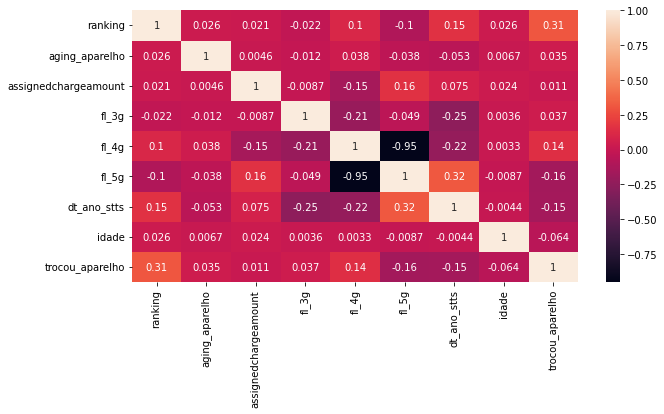

In [38]:
corr = corr_trocou_aparelho.corr()

fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, annot = True)

In [39]:
dados_droped['mes_jan'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-01') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-01')

dados_droped['mes_fev'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-02') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-02')

dados_droped['mes_mar'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-03') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-03')

dados_droped['mes_abr'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-04') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-04')

dados_droped['mes_mai'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-05') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-05')

dados_droped['mes_jun'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-06') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-06')

dados_droped['mes_jul'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-07') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-07')  
                                                
dados_droped['mes_ago'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-08') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-08')

dados_droped['mes_set'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-09') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-09')

dados_droped['mes_out'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-10') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-10')

dados_droped['mes_nov'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-11') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-11')

dados_droped['mes_dez'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-12') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-12')

In [40]:
corr_meses_troca = dados_droped[['mes_jan', 'mes_fev', 'mes_mar', 'mes_abr', 
								 'mes_mai', 'mes_jun', 'mes_jul', 'mes_ago', 
								 'mes_set', 'mes_out', 'mes_nov', 'mes_dez', 'trocou_aparelho']]

<AxesSubplot:>

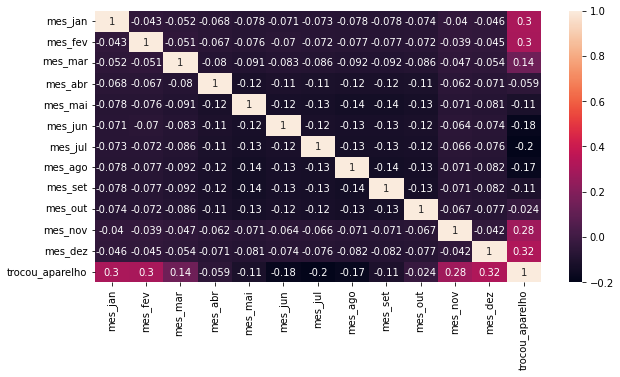

In [41]:
corr_Test = corr_meses_troca.corr()

fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(corr_Test, xticklabels = corr_Test.columns, yticklabels = corr_Test.columns, annot = True)

***
***
***
## Definição do Target trocou_aparelho

In [42]:
def plot_feature_freq(df, feature, qt_cat):
    labels, counts = np.unique(df[feature].dropna(), return_counts=True)

    # ordena pelas mais frequentes
    order = np.argsort(counts)[::-1]
    labels, counts = labels[order], counts[order]

    g = sns.barplot(labels[:qt_cat], counts[:qt_cat])
    g.set_xticklabels(labels[:qt_cat], rotation=90)
    
    return g

In [43]:
# define target
y_trocou_aparelho = dados_droped['trocou_aparelho']

c_trocou_aparelho = Counter(y_trocou_aparelho)
c_trocou_aparelho

Counter({1: 5819, 0: 12258})

In [44]:
# # calculo da proporção da base
# estimate = c_trocou_aparelho[0] / c_trocou_aparelho[1]
# estimate

<AxesSubplot:>

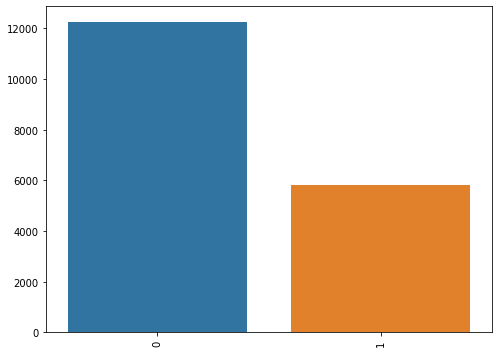

In [45]:
plt.figure(figsize=(8, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(dados_droped, 'trocou_aparelho', len(dados_droped['trocou_aparelho'].unique()))

***
## Modelagem trocou_aparelho

In [46]:
# Dividindo as features em dados de treino e teste
X_train_ta, X_val_ta, y_train_ta, y_val_ta = train_test_split(X_ta, 
                                                              y_trocou_aparelho, 
                                                              test_size=0.5, 
                                                              random_state = 2048)

# Pré-processamento para Dados Numéricos
numerical_transformer_ta = Pipeline([
                                     ('scaler', StandardScaler())
                                    ])

# Pré-processamento para Dados Categóricos
categorical_transformer_ta = Pipeline([
                                       ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
                                      ])

# Pré-processamento de pacote de dados numéricos e categóricos
preprocessor_ta = ColumnTransformer(transformers=[
                                                  ('num', numerical_transformer_ta, numerical_cols_ta),
                                                  ('cat', categorical_transformer_ta, object_cols_ta)
                                                 ], n_jobs=-1)

pipeline_ta = Pipeline(steps=[
                              ('preprocessor', preprocessor_ta),
                              ('smote', SMOTE(random_state=42, n_jobs=-1)),
#                               ('model', RandomForestClassifier(random_state=2048))
                              ('model', GradientBoostingClassifier(random_state=2048))
#                               ('model', XGBClassifier(scale_pos_weight=estimate, random_state=2048))
                             ])

# Preprocessing of training data, fit model 
pipeline_ta.fit(X_train_ta, y_train_ta)

# Predictions
# preds = np.asarray(pipeline.predict(X_val), dtype = 'int')
preds_ta = pipeline_ta.predict(X_val_ta)

In [47]:
c_train_ta = Counter(y_train_ta)
c_train_ta


Counter({0: 6145, 1: 2893})

In [48]:
c_val_ta = Counter(y_val_ta)
c_val_ta


Counter({1: 2926, 0: 6113})

In [49]:
c_preds_ta = Counter(preds_ta)
c_preds_ta

Counter({1: 3945, 0: 5094})

***
## Métricas

In [50]:
print(classification_report(y_val_ta, preds_ta))

              precision    recall  f1-score   support

           0       0.81      0.68      0.74      6113
           1       0.50      0.67      0.57      2926

    accuracy                           0.67      9039
   macro avg       0.65      0.67      0.66      9039
weighted avg       0.71      0.67      0.68      9039



In [51]:
cm_df_ta = pd.DataFrame(confusion_matrix(y_val_ta, preds_ta),
                     index = sorted(Counter(y_val_ta)),
                     columns = sorted(Counter(preds_ta)))
cm_df_ta

,0,1
0,4134,1979
1,960,1966


Confusion matrix, without normalization
[[4134 1979]
 [ 960 1966]]
Normalized confusion matrix
[[0.6762637  0.3237363 ]
 [0.32809296 0.67190704]]


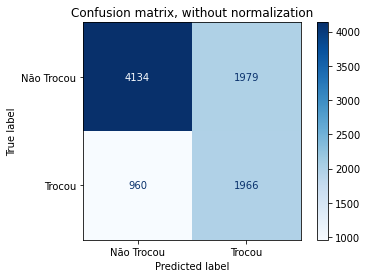

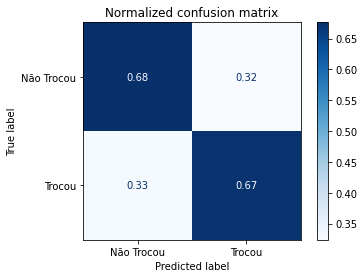

<Figure size 1296x1296 with 0 Axes>

In [52]:
# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        pipeline_ta,
        X_val_ta,
        y_val_ta,
        display_labels=['Não Trocou', 'Trocou'],
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
    
plt.figure(figsize=(18, 18))
plt.show()

## Captação dos clientes que foram previstos como Propensos a Fazer uma Compra

In [53]:
X_val_ta['trocou_aparelho'] = y_val_ta
# X_val_ta

<AxesSubplot:>

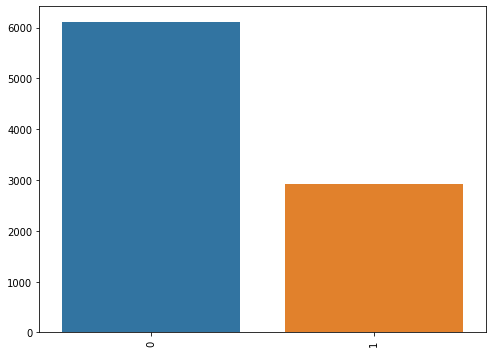

In [54]:
plt.figure(figsize=(8, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(X_val_ta, 'trocou_aparelho', len(X_val_ta['trocou_aparelho'].unique()))

In [55]:
X_val_ta['trocou_aparelho_previsto'] = preds_ta
# X_val_ta

<AxesSubplot:>

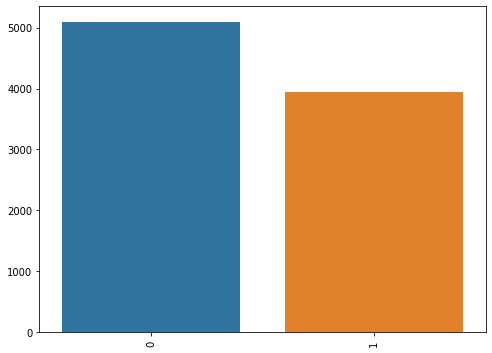

In [56]:
plt.figure(figsize=(8, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(X_val_ta, 'trocou_aparelho_previsto', len(X_val_ta['trocou_aparelho_previsto'].unique()))

In [57]:
X_val_ta['cpfidentifier'] = dados_droped['cpfidentifier']
# X_val_ta

In [58]:
X_val_ta['dt_inicio'] = dados_droped['dt_inicio']
# X_val_ta

In [59]:
X_val_ta['dt_fim'] = dados_droped['dt_fim']
X_val_ta

,fabricante,modelo,ranking,aging_aparelho,offertechnology,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,fl_5g,dt_ano_stts,idade,trocou_aparelho,trocou_aparelho_previsto,cpfidentifier,dt_inicio,dt_fim
2736,SAMSUNG,GALAXY GRAND PRIME DUOS (SM-G532MT),1,14,PostPaid,SAO PAULO,Linha Adicional Vivo PÃ³s FamÃ­lia 300GB,0.00,0.0,1.0,0.0,2017,69,1,1,53600487868,2020-12-24,2022-03-09
9312,SAMSUNG,"GALAXY S10 (SM-G973F,DS)",1,15,PostPaid,SAO PAULO,TITULAR VIVO FAMILIA 10GB+110GB BONUS,150.51,0.0,1.0,0.0,2018,32,0,1,39758735829,2021-07-12,NaN
13957,HUAWEI,FC612E,1,13,PostPaid,SAO PAULO,Titular Vivo PÃ³s 50GB,78.99,1.0,0.0,0.0,2010,46,0,1,24767407800,2021-09-05,NaN
4590,Samsung Korea,GALAXY S20,1,18,PostPaid,SAO PAULO,Linha Adicional Vivo PÃ³s FamÃ­lia 180GB,62.99,0.0,1.0,0.0,2019,32,0,1,40056003870,2021-04-06,NaN
15890,LG Electronics Inc.,LM-K410BMW,1,18,PostPaid,SAO PAULO,LINHA ADICIONAL VIVO FAMILIA 20GB+220GB BONUS,0.00,0.0,1.0,0.0,2019,68,0,0,59219890887,2021-04-10,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8170,Samsung Korea,GALAXY A01 CORE,1,15,PostPaid,SAO PAULO,Linha Adicional Vivo PÃ³s FamÃ­lia 180GB,0.00,0.0,1.0,0.0,2020,36,0,0,34975536897,2021-07-19,NaN
11917,SAMSUNG,"GALAXY A71 (SM-A715F,DSM)",1,13,PostPaid,SAO PAULO,TITULAR BASICO FUNCIONAL,0.00,0.0,1.0,0.0,2019,34,1,1,35884562870,2021-02-03,2022-04-02
12486,LG Electronics Inc.,K40S,1,16,PostPaid,SAO PAULO,TITULAR VIVO_POS 30GB,127.64,0.0,1.0,0.0,2019,36,0,1,35254199881,2021-06-07,NaN
13159,APPLE,IPHONE 12 PRO MAX (A2411),1,12,PostPaid,SAO PAULO,TITULAR VIVO V,876.70,0.0,0.0,1.0,2020,37,0,1,22795161877,2021-10-19,NaN


***
***
***
## Separando as bases para outro modelo

In [60]:
base_to_pred_month = X_val_ta[X_val_ta['trocou_aparelho_previsto'] == 1].reset_index(drop=True)
base_to_pred_month

,fabricante,modelo,ranking,aging_aparelho,offertechnology,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,fl_5g,dt_ano_stts,idade,trocou_aparelho,trocou_aparelho_previsto,cpfidentifier,dt_inicio,dt_fim
0,SAMSUNG,GALAXY GRAND PRIME DUOS (SM-G532MT),1,14,PostPaid,SAO PAULO,Linha Adicional Vivo PÃ³s FamÃ­lia 300GB,0.00,0.0,1.0,0.0,2017,69,1,1,53600487868,2020-12-24,2022-03-09
1,SAMSUNG,"GALAXY S10 (SM-G973F,DS)",1,15,PostPaid,SAO PAULO,TITULAR VIVO FAMILIA 10GB+110GB BONUS,150.51,0.0,1.0,0.0,2018,32,0,1,39758735829,2021-07-12,NaN
2,HUAWEI,FC612E,1,13,PostPaid,SAO PAULO,Titular Vivo PÃ³s 50GB,78.99,1.0,0.0,0.0,2010,46,0,1,24767407800,2021-09-05,NaN
3,Samsung Korea,GALAXY S20,1,18,PostPaid,SAO PAULO,Linha Adicional Vivo PÃ³s FamÃ­lia 180GB,62.99,0.0,1.0,0.0,2019,32,0,1,40056003870,2021-04-06,NaN
4,SAMSUNG,GALAXY S20 FE (SM-G780F),2,17,PostPaid,SAO PAULO,TITULAR VIVO FAMILIA 10GB+110GB BONUS,159.99,0.0,1.0,0.0,2020,93,1,1,25079382856,2021-05-12,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3940,APPLE,IPHONE 7 (A1778),1,14,PostPaid,SAO PAULO,TITULAR VIVO FAMILIA 10GB+110GB BONUS,159.99,0.0,1.0,0.0,2018,57,0,1,8785141801,2021-07-30,NaN
3941,SAMSUNG,"GALAXY A71 (SM-A715F,DSM)",1,13,PostPaid,SAO PAULO,TITULAR BASICO FUNCIONAL,0.00,0.0,1.0,0.0,2019,34,1,1,35884562870,2021-02-03,2022-04-02
3942,LG Electronics Inc.,K40S,1,16,PostPaid,SAO PAULO,TITULAR VIVO_POS 30GB,127.64,0.0,1.0,0.0,2019,36,0,1,35254199881,2021-06-07,NaN
3943,APPLE,IPHONE 12 PRO MAX (A2411),1,12,PostPaid,SAO PAULO,TITULAR VIVO V,876.70,0.0,0.0,1.0,2020,37,0,1,22795161877,2021-10-19,NaN


***
***
***
## Definição do Target aging_aparelho

In [61]:
# define target
y = base_to_pred_month['aging_aparelho']

In [62]:
# contagem de aging
from collections import Counter

c = Counter(y)
c

Counter({14: 645, 15: 578, 13: 598, 18: 494, 17: 522, 16: 464, 12: 644})

<AxesSubplot:>

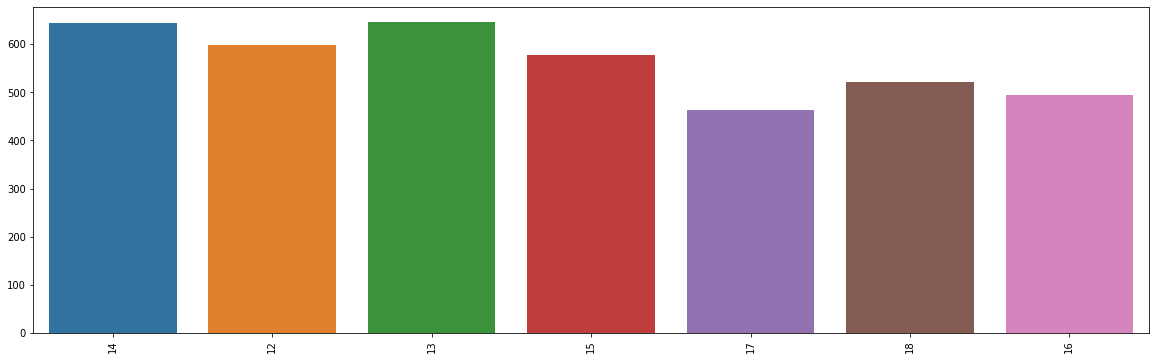

In [63]:
plt.figure(figsize=(20, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(base_to_pred_month, 'aging_aparelho', len(base_to_pred_month['aging_aparelho'].unique()))

### Definicão das features

In [64]:
# define features
X = base_to_pred_month[['fabricante', 'modelo',
                        'ranking',
                        'offertechnology', 
                        'statedesc', 'subscribermainofferdesc',
                        'assignedchargeamount', 'fl_3g', 'fl_4g', 'fl_5g',
                        'dt_ano_stts', 'idade']]
X

,fabricante,modelo,ranking,offertechnology,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,fl_5g,dt_ano_stts,idade
0,SAMSUNG,GALAXY GRAND PRIME DUOS (SM-G532MT),1,PostPaid,SAO PAULO,Linha Adicional Vivo PÃ³s FamÃ­lia 300GB,0.00,0.0,1.0,0.0,2017,69
1,SAMSUNG,"GALAXY S10 (SM-G973F,DS)",1,PostPaid,SAO PAULO,TITULAR VIVO FAMILIA 10GB+110GB BONUS,150.51,0.0,1.0,0.0,2018,32
2,HUAWEI,FC612E,1,PostPaid,SAO PAULO,Titular Vivo PÃ³s 50GB,78.99,1.0,0.0,0.0,2010,46
3,Samsung Korea,GALAXY S20,1,PostPaid,SAO PAULO,Linha Adicional Vivo PÃ³s FamÃ­lia 180GB,62.99,0.0,1.0,0.0,2019,32
4,SAMSUNG,GALAXY S20 FE (SM-G780F),2,PostPaid,SAO PAULO,TITULAR VIVO FAMILIA 10GB+110GB BONUS,159.99,0.0,1.0,0.0,2020,93
...,...,...,...,...,...,...,...,...,...,...,...,...
3940,APPLE,IPHONE 7 (A1778),1,PostPaid,SAO PAULO,TITULAR VIVO FAMILIA 10GB+110GB BONUS,159.99,0.0,1.0,0.0,2018,57
3941,SAMSUNG,"GALAXY A71 (SM-A715F,DSM)",1,PostPaid,SAO PAULO,TITULAR BASICO FUNCIONAL,0.00,0.0,1.0,0.0,2019,34
3942,LG Electronics Inc.,K40S,1,PostPaid,SAO PAULO,TITULAR VIVO_POS 30GB,127.64,0.0,1.0,0.0,2019,36
3943,APPLE,IPHONE 12 PRO MAX (A2411),1,PostPaid,SAO PAULO,TITULAR VIVO V,876.70,0.0,0.0,1.0,2020,37


#### Variaveis Categoricas

In [65]:
# Get list of categorical variables
s = (X.dtypes == 'object')
object_cols = list(s[s].index)
print("Categorical variables: ", len(object_cols))
print(object_cols)

Categorical variables:  5
['fabricante', 'modelo', 'offertechnology', 'statedesc', 'subscribermainofferdesc']


#### Variaveis Numéricas

In [66]:
# Criando uma lista de variaveis numéricas
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]
print("Numerical variables: ", len(numerical_cols))
print(numerical_cols)

Numerical variables:  7
['ranking', 'assignedchargeamount', 'fl_3g', 'fl_4g', 'fl_5g', 'dt_ano_stts', 'idade']


***
## Mostrando a correlação entre os dados numéricos

In [67]:
corr_mes_previsao = base_to_pred_month[['fabricante', 'modelo',
                                        'ranking',
                                        'offertechnology', 
                                        'statedesc', 'subscribermainofferdesc',
                                        'assignedchargeamount', 'fl_3g', 'fl_4g', 'fl_5g',
                                        'dt_ano_stts', 'idade', 'aging_aparelho']]

<AxesSubplot:>

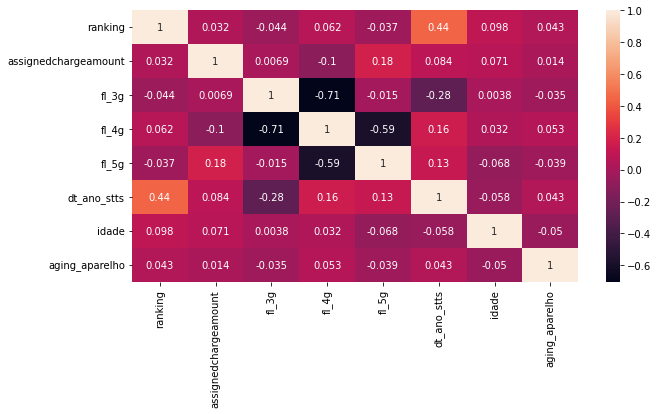

In [68]:
corr2 = corr_mes_previsao.corr()

fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(corr2, xticklabels = corr2.columns, yticklabels = corr2.columns, annot = True)

***
## Modelagem

In [69]:
# Dividindo as features em dados de treino e teste - 70% para dados de treinamento e 30% para dados de teste
X_train, X_val, y_train, y_val = train_test_split(X, 
                                                  y, 
                                                  test_size=0.5, 
                                                  random_state = 2048)

# Pré-processamento para Dados Numéricos
numerical_transformer = Pipeline([
                                  ('scaler', StandardScaler())
                                 ])

# Pré-processamento para Dados Categóricos
categorical_transformer = Pipeline([
                                    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
                                   ])

# Pré-processamento de pacote de dados numéricos e categóricos
preprocessor = ColumnTransformer(transformers=[
                                                ('num', numerical_transformer, numerical_cols),
                                                ('cat', categorical_transformer, object_cols)
                                              ], n_jobs=-1)

pipeline = Pipeline(steps=[
                            ('preprocessor', preprocessor),
#                             ('smote', SMOTE(random_state=42, n_jobs=-1)),
                            ('model', RandomForestClassifier(random_state=2048))
#                             ('model', GradientBoostingClassifier(random_state=2048))
#                             ('model', XGBClassifier(scale_pos_weight=estimate, random_state=2048))
                          ])

# Preprocessing of training data, fit model 
pipeline.fit(X_train, y_train)

# Predictions
#preds = np.asarray(pipeline.predict(X_val), dtype = 'int')
preds = pipeline.predict(X_val)

In [70]:
c_train = Counter(y_train)
c_train

Counter({17: 254, 13: 319, 15: 284, 14: 302, 18: 248, 12: 333, 16: 232})

In [71]:
c_val = Counter(y_val)
c_val

Counter({12: 311, 13: 279, 18: 246, 14: 343, 16: 232, 17: 268, 15: 294})

In [72]:
c_preds = Counter(preds)
c_preds

Counter({13: 358, 12: 387, 14: 292, 18: 204, 17: 245, 16: 190, 15: 297})

<AxesSubplot:>

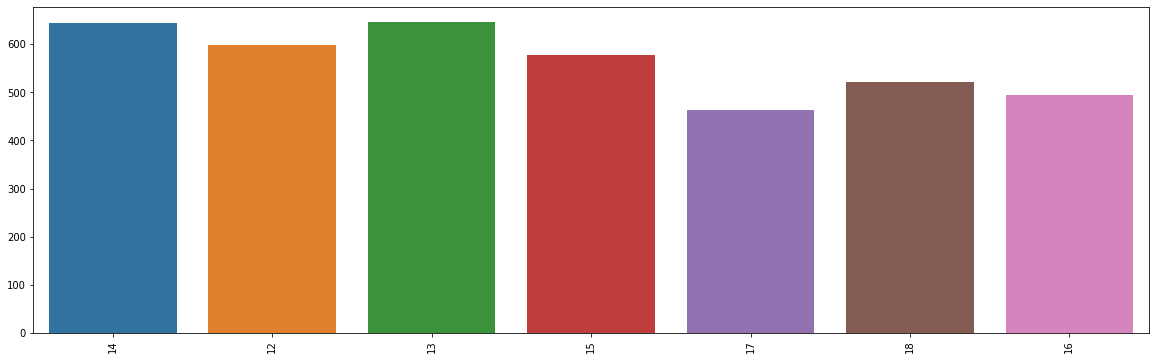

In [73]:
plt.figure(figsize=(20, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(base_to_pred_month, 'aging_aparelho', len(base_to_pred_month['aging_aparelho'].unique()))

***
## Métricas

In [74]:
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

          12       0.20      0.25      0.23       311
          13       0.19      0.24      0.21       279
          14       0.21      0.18      0.20       343
          15       0.19      0.19      0.19       294
          16       0.18      0.15      0.16       232
          17       0.22      0.20      0.21       268
          18       0.16      0.13      0.15       246

    accuracy                           0.20      1973
   macro avg       0.19      0.19      0.19      1973
weighted avg       0.19      0.20      0.19      1973



In [75]:
cm_df = pd.DataFrame(confusion_matrix(y_val, preds),
                     index = sorted(Counter(y_val)),
                     columns = sorted(Counter(preds)))
cm_df

,12,13,14,15,16,17,18
12,79,72,43,50,19,22,26
13,47,67,48,52,14,26,25
14,72,58,62,50,24,47,30
15,67,42,40,57,35,33,20
16,34,42,24,31,34,28,39
17,44,40,37,26,37,53,31
18,44,37,38,31,27,36,33


## Plot non-normalized confusion matrix

Confusion matrix, without normalization
[[79 72 43 50 19 22 26]
 [47 67 48 52 14 26 25]
 [72 58 62 50 24 47 30]
 [67 42 40 57 35 33 20]
 [34 42 24 31 34 28 39]
 [44 40 37 26 37 53 31]
 [44 37 38 31 27 36 33]]
Normalized confusion matrix
[[0.25401929 0.23151125 0.13826367 0.1607717  0.06109325 0.07073955
  0.08360129]
 [0.16845878 0.24014337 0.17204301 0.18637993 0.05017921 0.09318996
  0.08960573]
 [0.20991254 0.16909621 0.18075802 0.14577259 0.06997085 0.13702624
  0.08746356]
 [0.22789116 0.14285714 0.13605442 0.19387755 0.11904762 0.1122449
  0.06802721]
 [0.14655172 0.18103448 0.10344828 0.13362069 0.14655172 0.12068966
  0.16810345]
 [0.1641791  0.14925373 0.1380597  0.09701493 0.1380597  0.19776119
  0.11567164]
 [0.17886179 0.1504065  0.15447154 0.12601626 0.1097561  0.14634146
  0.13414634]]


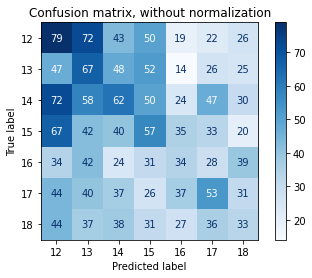

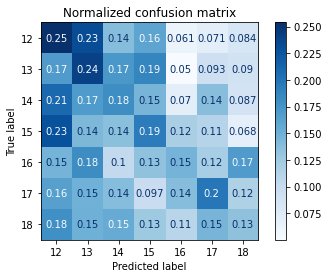

<Figure size 1296x1296 with 0 Axes>

In [76]:
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        pipeline,
        X_val,
        y_val,
        display_labels=['12', '13', '14', '15', '16', '17', '18'],
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
    
plt.figure(figsize=(18, 18))
plt.show()

***
## Mesclando resultados com tabela

### Com a base de validação

In [77]:
X_val['aging_aparelho'] = y_val
# X_val

In [78]:
X_val['previsto'] = preds
# X_val

In [79]:
X_val['cpfidentifier'] = base_to_pred_month['cpfidentifier']
# X_val

In [80]:
X_val['dt_inicio'] = base_to_pred_month['dt_inicio']
# X_val

In [81]:
X_val['dt_fim'] = base_to_pred_month['dt_fim']
# X_val

## Calculando data prevista

In [82]:
X_val['dt_fim_previsto'] = ((pd.to_datetime(X_val['dt_inicio']).dt.to_period('M')) + X_val['previsto'])
X_val

,fabricante,modelo,ranking,offertechnology,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,fl_5g,dt_ano_stts,idade,aging_aparelho,previsto,cpfidentifier,dt_inicio,dt_fim,dt_fim_previsto
92,SAMSUNG,GALAXY J7 PRIME (SM-G610M DS),1,PostPaid,SAO PAULO,LINHA ADICIONAL VIVO FAMILIA 200GB,0.00,0.0,1.0,0.0,2016,55,12,13,10225608839,2021-09-25,NaN,2022-10
2166,LG,G360,1,PostPaid,SAO PAULO,LINHA ADICIONAL VIVO FAMILIA 200GB_,0.00,0.0,0.0,0.0,2016,44,13,12,25515874846,2021-03-24,2022-05-23,2022-03
1118,APPLE,IPHONE 8 (A1905),1,PostPaid,SAO PAULO,TITULAR VIVO FAMILIA 100GB,259.26,0.0,1.0,0.0,2018,46,12,13,18587749854,2021-05-09,2022-05-12,2022-06
658,XIAOMI,MI 9T PRO (M1903F11G),1,PostPaid,SAO PAULO,Linha Adicional Vivo PÃ³s FamÃ­lia 180GB,0.00,0.0,1.0,0.0,2019,59,18,14,3467754856,2020-10-16,2022-05-07,2021-12
3753,"Motorola Mobility LLC, a Lenovo Company","DEEN, MOTOROLA ONE",1,PostPaid,SAO PAULO,LINHA ADICIONAL VIVO FAMILIA 10GB PLN+110GB BONUS,0.00,0.0,1.0,0.0,2018,23,18,18,49313342880,2020-08-24,2022-03-12,2022-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2313,APPLE,IPHONE 8 PLUS (A1897),1,PostPaid,SAO PAULO,TITULAR VIVO_POS 30GB,134.99,0.0,1.0,0.0,2017,32,18,16,38460578860,2021-03-23,NaN,2022-07
2471,APPLE,IPHONE 11 (A2221),1,PostPaid,SAO PAULO,Titular Vivo PÃ³s FamÃ­lia 120GB,138.99,0.0,1.0,0.0,2019,34,14,15,37054408888,2021-02-24,2022-05-09,2022-05
1355,SAMSUNG,"GALAXY A22 (SM-A225F,DS)",2,PostPaid,SAO PAULO,Titular Vivo PÃ³s 20GB,48.99,0.0,1.0,0.0,2021,50,12,12,14027778847,2021-10-11,NaN,2022-10
49,SAMSUNG,GALAXY J7 PRIME (SM-G610M DS),1,PostPaid,SAO PAULO,LINHA ADICIONAL VIVO FAMILIA 100GB,0.00,0.0,1.0,0.0,2017,51,13,17,17659303830,2021-08-30,NaN,2023-01


In [83]:
c_preds

Counter({13: 358, 12: 387, 14: 292, 18: 204, 17: 245, 16: 190, 15: 297})

<AxesSubplot:>

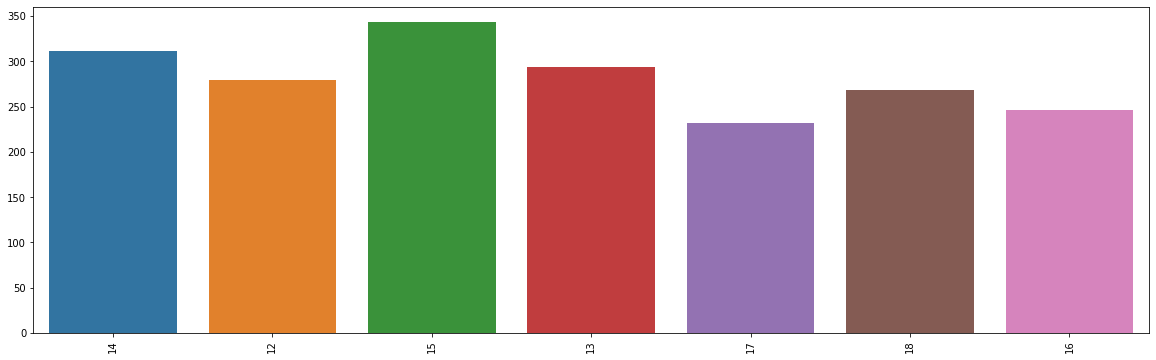

In [84]:
plt.figure(figsize=(20, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(X_val, 'aging_aparelho', len(X_val['aging_aparelho'].unique()))

<AxesSubplot:>

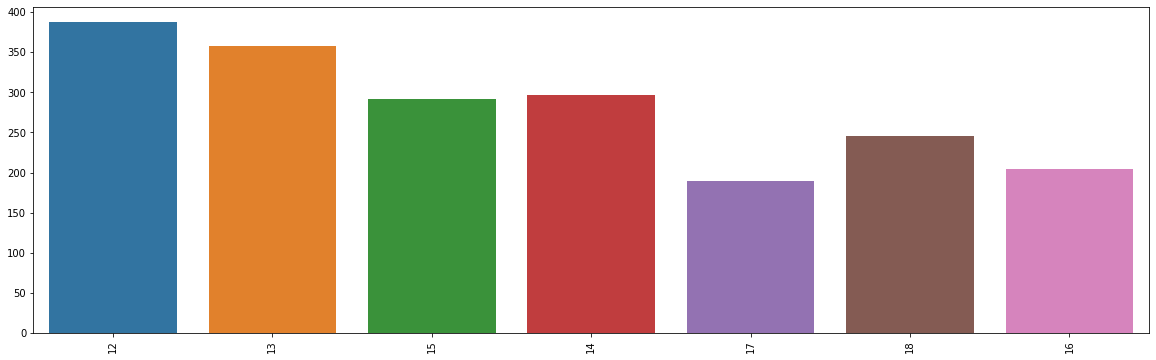

In [85]:
plt.figure(figsize=(20, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(X_val, 'previsto', len(X_val['previsto'].unique()))